## Initial logic

In [1]:
import pandas as pd
from pymongo import MongoClient
import matplotlib.pyplot as plt

# 1. DB connect
client = MongoClient("mongodb://mongodb:27017/")
db = client.stock_database
collection = db.prices

# 2. Gather data
cursor = collection.find({"asset": "NVDA"}).sort("Date", 1)
df = pd.DataFrame(list(cursor))

# 3. Prep Cols
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['DayNum'] = range(len(df))

print("Table created.")

Table created.


In [2]:
from sklearn.linear_model import LinearRegression

# Create model
model = LinearRegression()

print("Model created")

Model created


## Test Data


## Linear Regression

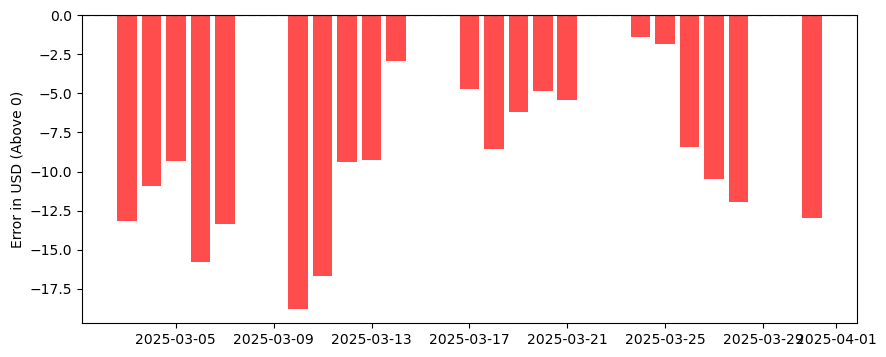

In [3]:
# 1. Create Model
model = LinearRegression()

# 2. Gather data for lear(01/02) and test (03)
train_jan_feb = df[df['Month'] <= 2]
test_march = df[df['Month'] == 3].copy()

# 3. Model train, looking at 01/02 data
model.fit(train_jan_feb[['DayNum']], train_jan_feb['Close'])

# 4. Predicting march
preds = model.predict(test_march[['DayNum']])

# 5. Analisys - diff between true state - model estimations
test_march['Difference'] = test_march['Close'] - preds

# 6. Chart
plt.figure(figsize=(10, 4))
plt.bar(test_march['Date'], test_march['Difference'], color='red', alpha=0.7)
plt.axhline(0, color='black', linestyle='--') 
plt.ylabel("Error in USD (Above 0)")
plt.show()

## SVR

In [4]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np

# 1. Data prepare
train_data = df[df['Month'] <= 2]
test_data = df[df['Month'] == 3].copy()

X_train = train_data[['DayNum']]
y_train = train_data['Close']
X_test = test_data[['DayNum']]

# 2. Create SVR
svr_model = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=100, gamma=0.1))

# 3. Train and predict
svr_model.fit(X_train, y_train)
svr_preds = svr_model.predict(X_test)

# 4. Append model to table to compare to previous chart
test_data['SVR_Predictions'] = svr_preds
test_data['SVR_Difference'] = test_data['Close'] - svr_preds

print("SVR Model trained")

SVR Model trained


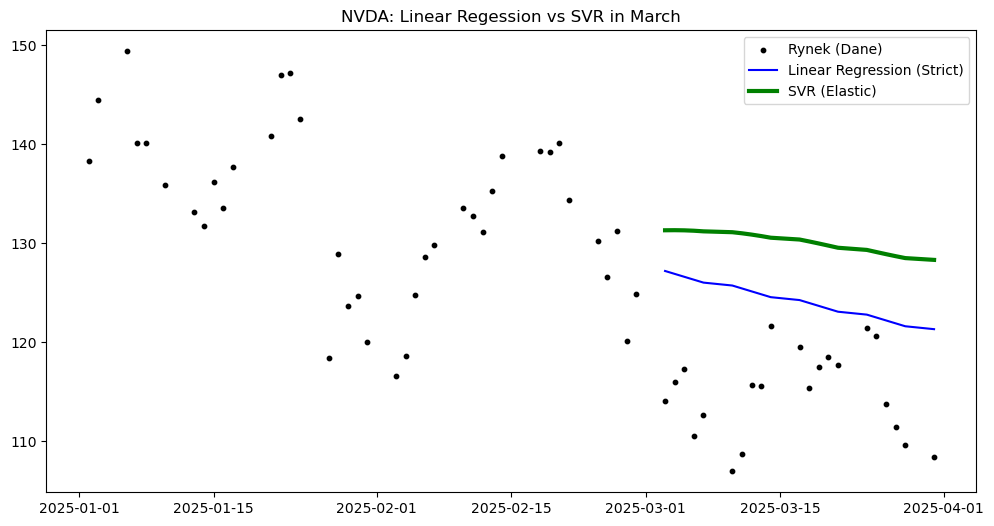

In [5]:
plt.figure(figsize=(12, 6))

# Get real prices
plt.scatter(df[df['Month'] <= 3]['Date'], df[df['Month'] <= 3]['Close'], color='black', s=10, label='Rynek (Dane)')


lin_preds = model.predict(X_test)
plt.plot(test_data['Date'], lin_preds, color='blue', label='Linear Regression (Strict)')


plt.plot(test_data['Date'], svr_preds, color='green', linewidth=3, label='SVR (Elastic)')

plt.title("NVDA: Linear Regession vs SVR in March")
plt.legend()
plt.show()

In [6]:
# Create copy of daya
df_ml = df.copy()

# Shift prices by one day
df_ml['Price_Yesterday'] = df_ml['Close'].shift(1)

# Drop 1st item as it is 1 jan, so no "day before"
df_ml = df_ml.dropna()

print("New Col'Price_Yesterday' ready")
print(df_ml[['Date', 'Close', 'Price_Yesterday']].head())

New Col'Price_Yesterday' ready
        Date       Close  Price_Yesterday
1 2025-01-03  144.430496       138.272171
2 2025-01-06  149.389130       144.430496
3 2025-01-07  140.101669       149.389130
4 2025-01-08  140.071701       140.101669
5 2025-01-10  135.872849       140.071701


In [7]:
# 1. New data arrange
train_data = df_ml[df_ml['Month'] <= 2]
test_data = df_ml[df_ml['Month'] == 3].copy()

# X'es with 2 cols now
features = ['DayNum', 'Price_Yesterday']
X_train = train_data[features]
y_train = train_data['Close']
X_test = test_data[features]

# 2. Create model
model_with_memory = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=100, gamma=0.1))
model_with_memory.fit(X_train, y_train)

# 3. Predict 03
preds_memory = model_with_memory.predict(X_test)
test_data['Memory_Predictions'] = preds_memory

print("Model trained!")

Model trained!


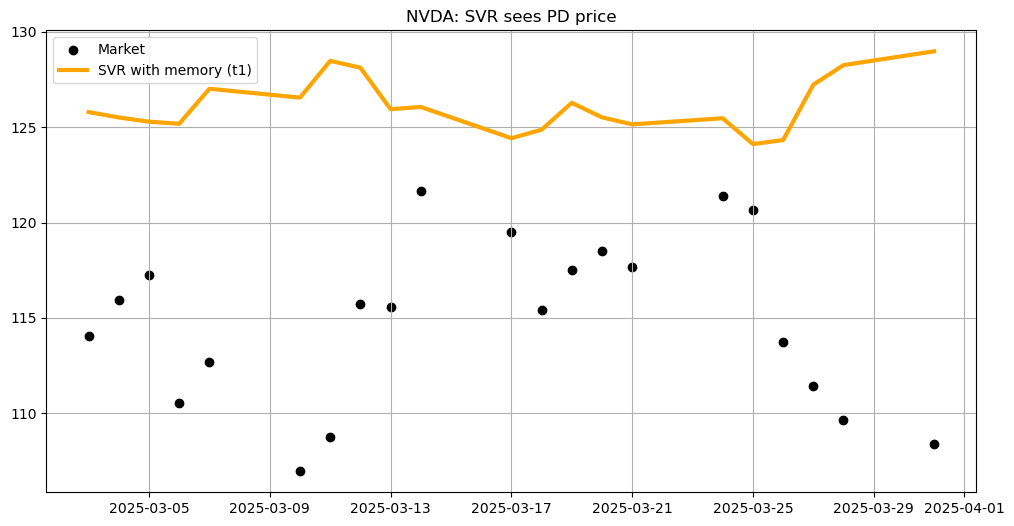

In [8]:
plt.figure(figsize=(12, 6))
plt.scatter(test_data['Date'], test_data['Close'], color='black', label='Market')
plt.plot(test_data['Date'], test_data['Memory_Predictions'], color='orange', linewidth=3, label='SVR with memory (t1)')
plt.title("NVDA: SVR sees PD price")
plt.legend()
plt.grid(True)
plt.show()

## Estimating dollar diffrence on prediction

In [9]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Obliczamy błąd dla modelu z pamięcią (t-1)
mae = mean_absolute_error(test_data['Close'], test_data['Memory_Predictions'])
mape = mean_absolute_percentage_error(test_data['Close'], test_data['Memory_Predictions'])

print(f"--- ERROR ANALYSIS (NVDA March) ---")
print(f"Medium error (MAE): {mae:.2f} USD")
print(f"Percentage error (MAPE): {mape*100:.2f}%")

# Poprawka: Obliczamy różnicę bezpośrednio, żeby nie szukać nieistniejącej kolumny
diff_memory = (test_data['Close'] - test_data['Memory_Predictions']).abs()
print(f"Biggest oneday mistake: {diff_memory.max():.2f} USD")

--- ERROR ANALYSIS (NVDA March) ---
Medium error (MAE): 11.22 USD
Percentage error (MAPE): 9.95%
Biggest oneday mistake: 20.62 USD


--- New results SVR + Median 5D ---
Medium error (MAE): 10.79 USD
Biggest diff: 21.03 USD


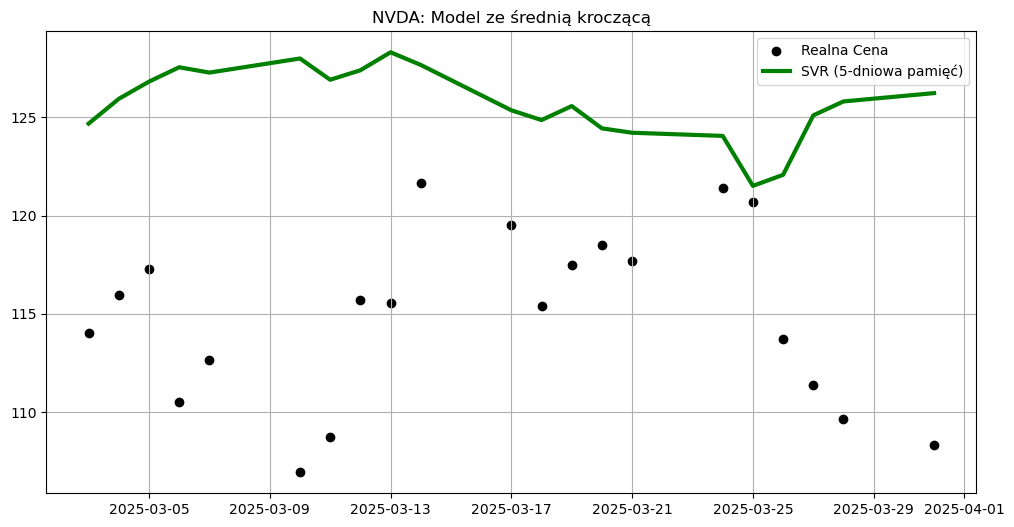

In [10]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# 1. Prep data, median from last 5 days and PD price
df_ml = df.copy()
df_ml['Price_Yesterday'] = df_ml['Close'].shift(1)
df_ml['Price_Avg_5d'] = df_ml['Close'].rolling(window=5).mean()
df_ml = df_ml.dropna()

# 2. Trening and test split
train_data = df_ml[df_ml['Month'] <= 2]
test_data = df_ml[df_ml['Month'] == 3].copy()

# 3. (x) and (y) definition
features_v3 = ['DayNum', 'Price_Yesterday', 'Price_Avg_5d']
X_train = train_data[features_v3]
y_train = train_data['Close']
X_test = test_data[features_v3]

# 4. SVR Training
model_v3 = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=100, gamma=0.1))
model_v3.fit(X_train, y_train)

# 5. Prediction and error calc
test_data['V3_Predictions'] = model_v3.predict(X_test)
test_data['V3_Error'] = (test_data['Close'] - test_data['V3_Predictions']).abs()

mae_v3 = mean_absolute_error(test_data['Close'], test_data['V3_Predictions'])
max_err_v3 = test_data['V3_Error'].max()

print(f"--- New results SVR + Median 5D ---")
print(f"Medium error (MAE): {mae_v3:.2f} USD")
print(f"Biggest diff: {max_err_v3:.2f} USD")

# 6. Wykres
plt.figure(figsize=(12, 6))
plt.scatter(test_data['Date'], test_data['Close'], color='black', label='Realna Cena')
plt.plot(test_data['Date'], test_data['V3_Predictions'], color='green', linewidth=3, label='SVR (5-dniowa pamięć)')
plt.title("NVDA: Model ze średnią kroczącą")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
results_live = []


for i in range(len(test_data)):
    
    current_train = pd.concat([train_data, test_data.iloc[:i]])
    
  
    model_live = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=100, gamma=0.1))
    model_live.fit(current_train[features_v3], current_train['Close'])
    
    
    pred = model_live.predict(test_data.iloc[[i]][features_v3])
    results_live.append(pred[0])

test_data['Live_Predictions'] = results_live
test_data['Live_Error'] = (test_data['Close'] - test_data['Live_Predictions']).abs()

print(f"Medium error live (MAE): {test_data['Live_Error'].mean():.2f} USD")

Medium error live (MAE): 4.54 USD


## GridSearchCV

In [12]:
from sklearn.model_selection import GridSearchCV


df_max = df.copy()
df_max['Price_Yesterday'] = df_max['Close'].shift(1)
df_max['Vol_Yesterday'] = df_max['Volume'].shift(1) # Dodajemy wolumen!
df_max['Price_Range'] = (df_max['High'] - df_max['Low']).shift(1) # Zmienność
df_max = df_max.dropna()


features_max = ['DayNum', 'Price_Yesterday', 'Vol_Yesterday', 'Price_Range']

train_data = df_max[df_max['Month'] <= 2]
test_data = df_max[df_max['Month'] == 3].copy()

results_final = []

for i in range(len(test_data)):
    current_train = pd.concat([train_data, test_data.iloc[:i]])
    
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(current_train[features_max])
    X_test_day = scaler.transform(test_data.iloc[[i]][features_max])
    
    model_final = SVR(kernel='rbf', C=500, gamma=0.01) 
    model_final.fit(X_train_scaled, current_train['Close'])
    
    pred = model_final.predict(X_test_day)
    results_final.append(pred[0])

test_data['Final_Predictions'] = results_final
test_data['Final_Error'] = (test_data['Close'] - test_data['Final_Predictions']).abs()

print(f"--- LAST RESULT ---")
print(f"Medium error (MAE): {test_data['Final_Error'].mean():.2f} USD")

--- LAST RESULT ---
Medium error (MAE): 3.57 USD
